# Self-training for ASR with HuggingFace

Performance of atomatic speech recognition (ASR) models had increased substantially during last years. Unfortunatly the performance on low resource languages might still be mediocre.
To improve the performance in low data regime self-training is often employed. Noizy-student[ref] is popular self-training method. Iterative pseudo-labeling is particularly well suited for ASR. One can fuse audio model with language model to improve the speech recognition performance. Language model not only provides a mean to improve quality of pseudo-labels but also the LM fusion scores can be used to filter pseudo labeled data to select most confident samples. In this notebook I employ simple heuristic for filtering the data introduced in [Improved Noisy Student Training for Automatic Speech Recognition](https://arxiv.org/abs/2005.09629).

I'm using [pyctcdecode] - integrating LM to ASR system. For detailed introduction to training KenLM and using it with HuggingFace refer to [this  exelent blogpost](https://huggingface.co/blog/wav2vec2-with-ngram).

In [ ]:
# !pip install git+https://github.com/arampacha/transformers.git@wav2vec2-with-lm-decode-score

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from transformers import (
    Wav2Vec2ProcessorWithLM, 
    Wav2Vec2Processor, 
    AutoFeatureExtractor,
    Wav2Vec2ForCTC,
)

from datasets import load_dataset, load_metric, Audio

In [2]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        
        if "labels" in features[0].keys():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            with self.processor.as_target_processor():
                labels_batch = self.processor.pad(
                    label_features,
                    padding=self.padding,
                    return_tensors="pt",
                )

            # replace padding with -100 to ignore loss correctly
            labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

            batch["labels"] = labels

        return batch

## Scores for filtering

The first we need a model trained on labeled data. Common Voice dataset has 738 training samples for Armenian and I haven't found any additional labeled data publically available.
The model pretrained on Common Voice is available [here](). It achieves 22.6 word error rate (WER) with LM boosted decoding.

Notice that large ASR models like those of Wav2Vec2-XLS-R family can learn grammar in some extent. At some point during training the model can start to overfit to train set vocab. The valid loss stops decreasing while validation WER still improves. In my experience validation loss is better indicator of performance after LM fusion.

In [3]:
# model_dir = "arampacha/wav2vec2-xls-r-1b-hy-cv"
model_dir = "/workspace/output/hy/models/wav2vec2-xls-r-1b-hy/"
lang_id = "hy-AM"

In [4]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained(model_dir)

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [5]:
@torch.no_grad()
def predict(model, dataset, bs=32, device="cpu"):
    model.eval()
    model.to(device)
    loader = DataLoader(
        dataset, batch_size=bs, collate_fn=data_collator, shuffle=False, drop_last=False, num_workers=4
    )
    all_logits = []
    for batch in tqdm(loader):
        batch = {k:v.to(device) for k,v in batch.items()}
        logits = model(**batch).logits.cpu()
        all_logits.append(logits)
    lens = [logits.shape[1] for logits in all_logits]
    max_len = max(lens)
    all_logits = [F.pad(logits, (0, 0, 0, max_len-l), value=-100.) for logits, l in zip(all_logits, lens)]
    return torch.cat(all_logits)

In [7]:
device = torch.device("cuda")

In [8]:
model = Wav2Vec2ForCTC.from_pretrained(model_dir)
model.to(device);
model.eval();

In [9]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="train+validation", use_auth_token=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="test", use_auth_token=True)
common_voice_train = common_voice_train.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))

Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)


In [10]:
import re
chars_to_remove_regex = re.compile("[^\sաբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆև]")
# chars_to_remove_regex = re.compile("[^\sაბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ]")

def normalize_text(batch):
    text = re.sub(chars_to_remove_regex, '', batch["sentence"].lower())
    batch["sentence"] = " ".join(text.split())
    return batch

In [11]:
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-8947d152a058d089.arrow
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-384d3b34b773bbe8.arrow


In [12]:
test_transcripts = common_voice_test["sentence"]
test_transcripts[:5]

['վատիկանի թանգարանները համարվում են աշխարհում ամենամեծ թանգարաններից մեկը',
 'լոյանը չինական հնագույն բնակավայրերից է',
 'կան նաև սանրեր կենդանիների բրդի համար',
 'այդպես կայացել է նրանց ծանոթությունը',
 'որոշումը ենթարկվել է քննադատության']

In [13]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [14]:
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

0ex [00:00, ?ex/s]

In [15]:
logits = predict(model, common_voice_test, device=device).numpy()

  0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [17]:
lm_params = {"alpha":0.5, "beta":1.5}
best_wer = 1.

print(f"alpha\t| beta\t| wer\t\t| cer")
for alpha in [0.5, 0.6, 0.7, 0.8]:
    for beta in [1.5, 2., 2.5, 3.,]:
        processor.decoder.reset_params(alpha=alpha, beta=beta)
        decoded_preds = processor.batch_decode(logits, beam_width=100, num_processes=8)
        wer = wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
        cer = cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
        if wer < best_wer:
            lm_params["alpha"] = alpha
            lm_params["beta"] = beta
            best_wer = wer
        print(f"{alpha}\t| {beta}\t| {wer:.4f}\t| {cer:.4f}")
        
print("\nBest LM parameters: ", lm_params)

alpha	| beta	| wer		| cer


Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f734d3e8d30>Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f734d3e8d30>  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

      File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError
:   File "/opt/conda/lib/python3.8/multiprocessi

0.5	| 1.5	| 0.1054	| 0.0216
0.5	| 2.0	| 0.1077	| 0.0221
0.5	| 2.5	| 0.1101	| 0.0225
0.5	| 3.0	| 0.1112	| 0.0229
0.6	| 1.5	| 0.1046	| 0.0213
0.6	| 2.0	| 0.1058	| 0.0214
0.6	| 2.5	| 0.1058	| 0.0214
0.6	| 3.0	| 0.1081	| 0.0218
0.7	| 1.5	| 0.1030	| 0.0209
0.7	| 2.0	| 0.1034	| 0.0210
0.7	| 2.5	| 0.1050	| 0.0212
0.7	| 3.0	| 0.1054	| 0.0213
0.8	| 1.5	| 0.1038	| 0.0213
0.8	| 2.0	| 0.1027	| 0.0212
0.8	| 2.5	| 0.1027	| 0.0212
0.8	| 3.0	| 0.1030	| 0.0212

Best LM parameters:  {'alpha': 0.8, 'beta': 2.0}


In [18]:
processor.decoder.reset_params(**lm_params)
decoded_preds = processor.batch_decode(logits, beam_width=100, num_processes=8)

In [19]:
import random

ids = random.sample(range(len(common_voice_test)), k=5)
for i in ids:
    print(decoded_preds.logit_score[i], decoded_preds.lm_score[i])
    print(decoded_preds.text[i])
    print(test_transcripts[i])

-22.672472029318136 -80.05733217749656
դասական և միջնադարյան հայկական ճարտարապետությունը պաշտպանվում է չորս կաղանձին շրջաններին
դասական և միջնադարյան հայկական ճարտարապետությունը բաժանվում է չորս առանձին շրջանների
-7.328563868977654 -44.31000123220482
որմնանկարները ծածկվեցին սվաղով սրբանկարները ավերվեցին զանգերը ցացնետվեցին
որմնանկարները ծածկվեցին սվաղով սրբանկարները ավերվեցին զանգերը ցած նետվեցին
-0.151528655956438 -9.897529828433772
գյուղում զբաղվում էին հողագործությամբ
գյուղում զբաղվում էին հողագործությամբ
-1.742148716937843 -39.06004656613231
մանկուց հրապուրվել է գրական ստեղծագործությամբ գրել բանաստեղծություններ
մանկուց հրապուրվել է գրական ստեղծագործությամբ գրել բանաստեղծություններ
-1.016097483215085 -20.555823327881992
մարմի կառուցվածքը շատ մեծ է և ճարպոտ
մարմնի կառուցվածքը շատ մեծ է և ճարպոտ


`pyctcdecode` does beam search for decoding. Candidate sequences are selected by the negative log likelihood. Total score is composed of NLL assigned to token sequence by the model and NLL score from language model.
Negative log likelihood of sequence is a sum of NLLs of individual elements. Therefore the score returned by decoder is not suited well for filtering the generated labels: longer sequences are expected to have lower score. To adjust the scores for filtering I'm adopting an approach from [Improved Noisy Student Training for Automatic Speech Recognition](https://arxiv.org/abs/2005.09629).
$$ (s_{lm} - \alpha*l - \beta)/ (\sigma \sqrt l) $$

In [20]:
text_length = np.array([len(s) for s in decoded_preds.text])
lm_scores = np.array(decoded_preds.lm_score)

In [21]:
wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)

0.10265417642466823

In [22]:
cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)

0.021193727870510874

In [23]:
example_wer = np.array([wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(decoded_preds.text, test_transcripts)])
example_wer.mean()

0.10425082380306261

It's easy to fit a line to the data. For instance one can `scikit-learn` library for this purpose.

In [24]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(np.expand_dims(np.array(text_length), axis=1), np.array(decoded_preds.lm_score))

a = reg.coef_[0]
b = reg.intercept_
print(f"{a:.7f}, {b:.7f}")

-0.4043058, -9.6834198


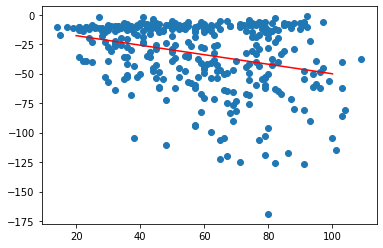

In [25]:
fig, ax = plt.subplots()
ax.scatter(text_length, decoded_preds.lm_score)
x = np.array([20, 100])
ax.plot(x, a*x+b, "r")
plt.show()

In [26]:
scores = (lm_scores - a*text_length - b)/ np.sqrt(text_length)
std = scores.std()
print(std)

3.5601210710004674


In [27]:
scores  = scores/ scores.std()

Finally we can check how the filtering reflects on the label quality.

In [61]:
mask = scores > -.5

print(f"Selected {mask.sum()}/{len(mask)} examples after filtering with average WER {example_wer[mask].mean():.5f}")

Selected 247/335 examples after filtering with average WER 0.0498973248973249


## Pseudo-labeling

For dataset generation I'm using [VoxLingua107](http://bark.phon.ioc.ee/voxlingua107/) dataset. 

In [33]:
unsup_dataset = load_dataset("/workspace/data/scripts/voxlingua107.py", "hy", split="train")
len(unsup_dataset)

Downloading:   0%|          | 0.00/7.05G [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset vox_lingua107 downloaded and prepared to /workspace/cache/hf/datasets/vox_lingua107/hy/0.0.0/92f9b48de9b7250925c8d895423b1e5e809f341da44e36e62b481c87fe6a1ca4. Subsequent calls will reuse this data.


24868

In [34]:
from datasets import load_dataset, Dataset, Audio, load_from_disk

In [35]:
sampling_rate = 16_000
unsup_dataset = unsup_dataset.cast_column("audio", Audio(sampling_rate))

In [36]:
unsup_dataset[0]

{'path': '/workspace/cache/hf/datasets/downloads/extracted/e2c69883717bc530ea985b078278eca672e297147dc25dbe8b1c2e751186f304/hy/PtZMJZrea3w__U__S1---0292.510-0301.900.wav',
 'audio': {'path': '/workspace/cache/hf/datasets/downloads/extracted/e2c69883717bc530ea985b078278eca672e297147dc25dbe8b1c2e751186f304/hy/PtZMJZrea3w__U__S1---0292.510-0301.900.wav',
  'array': array([-0.00149536, -0.00271606, -0.00183105, ..., -0.00839233,
         -0.0062561 , -0.00439453]),
  'sampling_rate': 16000}}

In [37]:
unsup_dataset = unsup_dataset.map(lambda s: {"duration": len(s["audio"]["array"]) / sampling_rate})

0ex [00:00, ?ex/s]

In [38]:
durs = np.array(unsup_dataset["duration"])

durs.mean(), durs.std(), durs.min(), durs.max()

(9.97123931106241, 4.763985759128929, 1.89, 20.0)

In [39]:
filtered_dataset = unsup_dataset.filter(lambda x: (3. < x < 16.), input_columns="duration")
len(filtered_dataset)

  0%|          | 0/25 [00:00<?, ?ba/s]

20694

In [40]:
filtered_dataset = filtered_dataset.sort("duration")

In [41]:
durs = np.array(filtered_dataset["duration"])

durs.mean(), durs.std(), durs.min(), durs.max()

(8.68453510377404, 3.5985018135481797, 3.01, 15.99)

In [42]:
def preprocess(batch):
    audio = batch["audio"]
    
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    # batch["length"] = len(batch["input_values"])
    return batch

In [43]:
processed_dataset = filtered_dataset.map(preprocess, remove_columns=filtered_dataset.column_names, num_proc=4)

## VoxLingua inference

In [44]:
vl_logits = predict(model, processed_dataset, device="cuda", bs=32).numpy()

  0%|          | 0/647 [00:00<?, ?it/s]

In [45]:
np.save("voxlingua_hy_logits_4.npy", vl_logits)

In [11]:
# vl_logits = np.load("voxlingua_hy_logits_4.npy")

In [46]:
vl_logits.shape

(20694, 799, 44)

In [47]:
vl_decoded_preds = processor.batch_decode(vl_logits, beam_width=150, num_processes=8)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f734d3e8d30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f734d3e8d30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

In [48]:
vl_decoded_preds.text[:10]

['ճանապարհի կեսն է',
 'ասում է գնում էին երևան',
 'ինչ վերաբերվում է ամքոր միջազգային կազմակերպության',
 'հիմնականում այս ընկերություները գնում են սիրիկոնյան հովիտ',
 'տարածման ժամանակակից ու արդյունավետ այդ ձևը',
 'ինչու նաև',
 'ռոբերտ քոչարյանի փաստաբանների ընտրած մարտավարության',
 'աննա գրիգորյան գևորգ մանուկյան աշոտ սարգսյան այսօր',
 'փաստեր ա թե ինչ է կատարվում ինչ',
 'այլապես այս քամբեքը իրականություն չէր դառնա']

In [49]:
vl_decoded_preds.lm_score[:10]

[-8.675891839188985,
 -12.99913310152822,
 -24.860925713660052,
 -80.80549045196803,
 -25.86412645281233,
 -8.711139445646014,
 -17.88565694353903,
 -25.585305771572695,
 -30.611772528046217,
 -48.159410055775986]

In [50]:
text_length = np.array([len(s) for s in vl_decoded_preds.text])
lm_scores = np.array(vl_decoded_preds.lm_score)

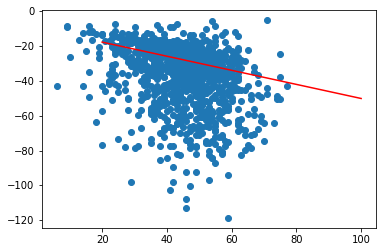

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(text_length[:1000], lm_scores[:1000])
x = np.array([20, 100])
ax.plot(x, a*x+b, "r")

In [52]:
vl_scores = (lm_scores - a*text_length - b)/ np.sqrt(text_length) / std

In [62]:
mask = vl_scores > -.5

print(f"Selected {mask.sum()}/{len(mask)} examples after filtering")

Selected 8169/20694 examples after filtering


In [63]:
len(common_voice_train)

728

In [64]:
idx = np.arange(len(mask))[mask]
print("lm_score\t|adj_score\t| text")
print("-"*100)
for i, _ in zip(idx, range(10)):
    
    print(f"{lm_scores[i]:.2f}\t\t|{vl_scores[i]:.2f}\t\t|", vl_decoded_preds.text[i])

lm_score	|adj_score	| text
----------------------------------------------------------------------------------------------------
-8.68		|0.53		| ճանապարհի կեսն է
-13.00		|0.35		| ասում է գնում էին երևան
-24.86		|0.20		| ինչ վերաբերվում է ամքոր միջազգային կազմակերպության
-25.86		|0.05		| տարածման ժամանակակից ու արդյունավետ այդ ձևը
-8.71		|0.43		| ինչու նաև
-17.89		|0.49		| ռոբերտ քոչարյանի փաստաբանների ընտրած մարտավարության
-25.59		|0.17		| աննա գրիգորյան գևորգ մանուկյան աշոտ սարգսյան այսօր
-30.61		|-0.42		| փաստեր ա թե ինչ է կատարվում ինչ
-25.45		|0.09		| ճնշման կամ պատասխանատվության տակ ամբողջ հարց
-22.74		|0.15		| ենթադրում է որ պետություն չկար մեծ հաշվով


In [66]:
labeled_dataset = filtered_dataset.select(idx)

In [67]:
paths = labeled_dataset["path"]
type(paths), len(paths)

(list, 8169)

In [68]:
from datasets import Dataset, DatasetDict

labeled_dataset = Dataset.from_dict({"path":paths, "audio":paths, "sentence":[vl_decoded_preds.text[i] for i in idx]})

In [69]:
labeled_dataset = labeled_dataset.cast_column("audio", Audio(sampling_rate))

In [70]:
labeled_dataset.save_to_disk("/workspace/data/hy/vox_lingua_hy_labeled_4")

In [71]:
from datasets import interleave_datasets, concatenate_datasets, DatasetDict, load_from_disk

In [72]:
len(labeled_dataset)

8169

In [73]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="train+validation", use_auth_token=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="test", use_auth_token=True)
common_voice_train = common_voice_train.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-8947d152a058d089.arrow
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-384d3b34b773bbe8.arrow


In [74]:
probs = np.array([len(common_voice_train), len(labeled_dataset)]) / (len(common_voice_train) + len(labeled_dataset))
probs

array([0.08182533, 0.91817467])

In [75]:
# train_dataset = interleave_datasets([common_voice_train, labeled_dataset], probabilities=probs)
train_dataset = concatenate_datasets([common_voice_train, labeled_dataset])

In [76]:
len(train_dataset)

8897

In [77]:
noizy_student_ds = DatasetDict({"train":train_dataset, "test":common_voice_test})

In [78]:
noizy_student_ds.save_to_disk("/workspace/data/hy/noizy_student_4")

In [59]:
# noizy_student_ds = load_from_disk("/workspace/data/hy/noizy_student_3/train")
# len(noizy_student_ds)

7284

You might also check out some of the selected samples to assess label quality manually. Even

In [80]:
import IPython.display as ipd
import numpy as np
import random

i = int(random.choice(idx))

print(vl_decoded_preds.text[i])
print(f"lm_score {lm_scores[i]:.2f}| score {vl_scores[i]:.2f}")
ipd.Audio(data=filtered_dataset[i]["audio"]["array"], autoplay=True, rate=16000)

եւ գործունեության արդյունավետության և ընդհանրապես որպես ազգային համախմբման կարևոր ինստիտուտ
lm_score -37.34| score 0.27
